In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as img

import json

from torchvision import transforms as T
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms.functional as F

import torch
import os

import numpy as np


from torch.utils.data import DataLoader
from tqdm import tqdm

import cv2

import clip
from PIL import Image

import torch.nn as nn

from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

from prettytable import PrettyTable

import optuna

In [23]:
def get_features(model, dataset):
    all_features = []
    all_labels = []
    
    with torch.no_grad():
        for images, texts, labels, path in tqdm(DataLoader(dataset, batch_size=100)):
            
            image_input = torch.tensor(np.stack(images)).cuda()
            #text_tokens = clip.tokenize([desc[:77] for desc in texts]).cuda()
            
            image_features = model.encode_image(image_input).type(torch.float).cpu()
            #text_features = model.encode_text(text_tokens).type(torch.float).cpu()

            #features = torch.cat([image_features, text_features], dim=1)
            
            all_features.extend(image_features)
            all_labels.extend(labels)

    return all_features, all_labels


def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']


def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs, scheduler):    
    best_model_name = None
    loss_history = []
    train_history = []
    val_history = []
    top_val_accuracy = 0.52 
    for epoch in range(num_epochs):
        model.train()
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
            x=x.type(torch.float).cpu()
            y = y.type(torch.float).cpu()
            model = model.cpu()
            prediction = model(x)    
            loss_value = loss(prediction, y.type(torch.long))
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / (i_step + 1)
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        if scheduler != None:
            scheduler.step()

        print("Epoch: %i lr: %f; Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (epoch, get_lr(optimizer), ave_loss, train_accuracy, val_accuracy))

  
        if val_accuracy > top_val_accuracy:
            top_val_accuracy = val_accuracy
            model_name = f'classifier_{epoch}_{round(val_accuracy, 3)}.ckpt'
            best_model_name = model_name
            torch.save(model, open(model_name, 'wb'))
            print("saved", model_name)

    return loss_history, train_history, val_history, best_model_name
        
    
def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader    
    Returns: accuracy as a float value between 0 and 1
    """
    model.eval()
    correct_samples = 0
    total_samples = 0 
    for i_step, (x, y) in enumerate(loader):
        prediction = model(x)
        _, indices = torch.max(prediction, 1)
        correct_samples += torch.sum(indices == y)
        total_samples += y.shape[0]            

    val_accuracy = float(correct_samples) / total_samples
         
    return val_accuracy

In [3]:
prettyTable = PrettyTable(['Model name', 'Accuracy', 'ROC AUC'])

In [4]:
from classes.transforms.CropCenter import CropCenter
from classes.transforms.ScaleMaxSideToSize import ScaleMaxSideToSize
from classes.dataset.HatefulMemesDataset import HatefulMemesDataset
from classes.dataset.FeaturesDataset import FeaturesDataset

In [5]:
CROP_SIZE=224

In [6]:
data_dir = r'E:\coding\HimariO\HatefulMemesChallenge\data\hateful_memes\\'

In [7]:
train_path = data_dir + 'train.jsonl'
dev_path = data_dir + 'dev.jsonl'

train_data = pd.read_json(train_path, lines=True)
test_data = pd.read_json(dev_path, lines=True)

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [9]:
clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

### CLIP zero-shot learning

In [10]:
#https://github.com/openai/CLIP
model, preprocess = clip.load("ViT-L/14", device=device)

image = preprocess(Image.open("CLIP.png")).unsqueeze(0).to(device)
text = clip.tokenize(["a diagram", "a dog", "a cat"]).to(device)

with torch.no_grad():
    image_features = model.encode_image(image)
    text_features = model.encode_text(text)
    
    logits_per_image, logits_per_text = model(image, text)
    probs = logits_per_image.softmax(dim=-1).cpu().numpy()

print("Label probs:", probs)  # prints: [[0.9927937  0.00421068 0.00299572]]

Label probs: [[0.946    0.04822  0.005985]]


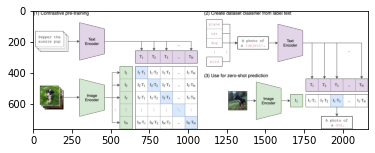

In [11]:
plt.imshow(Image.open("CLIP.png"))

In [12]:
preprocess

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=None)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x0000028986E3C040>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

#### Предобработка изображений

In [13]:
MEAN = torch.tensor([0.485, 0.456, 0.406])
STD = torch.tensor([0.229, 0.224, 0.225])

In [14]:
transforms = T.Compose([
    ScaleMaxSideToSize(CROP_SIZE),
    CropCenter(CROP_SIZE),
    T.ToTensor(),
    T.Normalize(mean=MEAN, std=STD),
])


In [15]:
train_dataset = HatefulMemesDataset(train_path, transforms)
val_dataset = HatefulMemesDataset(dev_path, transforms)

  0%|                                                                                                                                                        | 0/1063 [00:00<?, ?it/s]


('its their character not their color that matters', "don't be afraid to love again everyone is not like your ex", 'putting bows on your pet', 'i love everything and everybody! except for squirrels i hate squirrels', 'everybody loves chocolate chip cookies, even hitler', 'go sports! do the thing! win the points!', "fine you're right. now can we fucking drop it?", 'tattoos are bad for your health i know 5 million people that had tattoos and they all died')


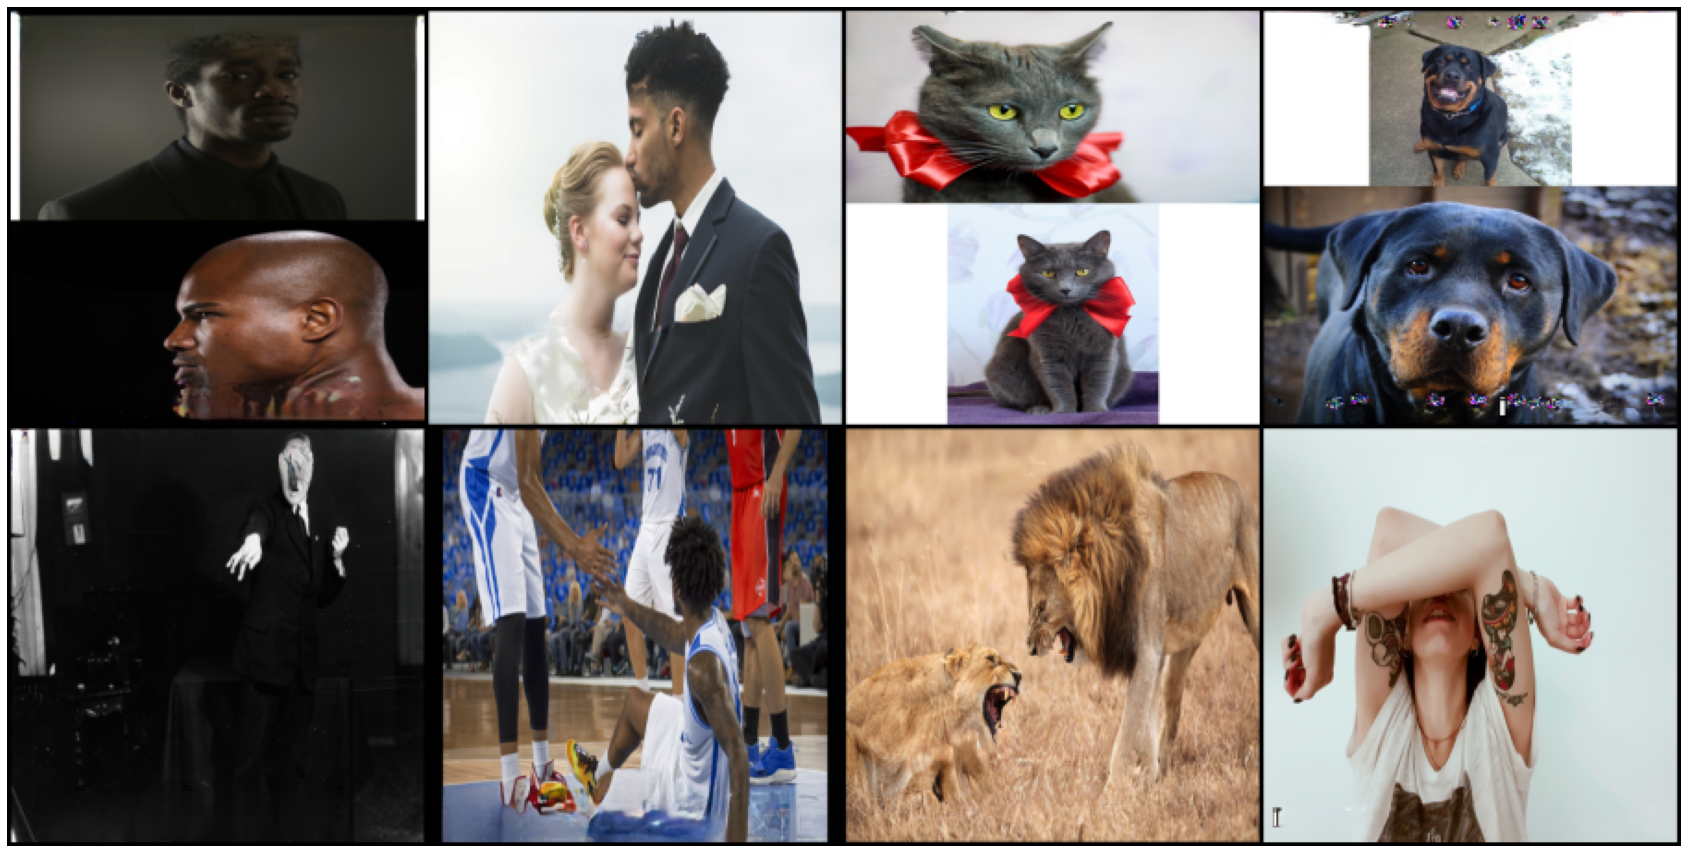

In [16]:
for images, texts, labels, path in tqdm(DataLoader(train_dataset, batch_size=8)):
    #print(images[0].shape, texts[0], labels[0] , labels.shape)
    break
    
grid = torchvision.utils.make_grid([(x * STD[:, None, None] + MEAN[:, None, None]) for x in images], nrow = 4)#
plt.figure(figsize=(30,20)); 
plt.axis(False)
plt.imshow(F.to_pil_image(grid));

print(texts)

#### Извлекаем признаки из текста и картинок

In [17]:
features_train, labels_train = get_features(model, train_dataset)
features_val, labels_val = get_features(model, val_dataset)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.21s/it]


In [18]:
features_train_dataset = FeaturesDataset(features_train, labels_train)
features_val_dataset = FeaturesDataset(features_val, labels_val)

#### Обучение нейросети

In [19]:
input_shape = features_train_dataset[0][0].shape[0]
num_classes = 2

In [ ]:
input_shape

In [24]:
torch.manual_seed(1024)

shape = 256
nn_model = nn.Sequential(
            nn.Linear(input_shape, shape),
            nn.Dropout(0.66),
            nn.BatchNorm1d(shape),
            nn.ReLU(inplace=True),    
    
            nn.Linear(shape, shape),
            nn.Dropout(0.66),
            nn.BatchNorm1d(shape),
            nn.ReLU(inplace=True),    
    
            nn.Linear(shape, num_classes),
            )

print(nn_model)
loss = nn.CrossEntropyLoss().cpu()
optimizer = torch.optim.Adam(nn_model.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.8)

loss_history, train_history, val_history, best_model_name = train_model(
    nn_model, 
    DataLoader(features_train_dataset, batch_size=500),
    DataLoader(features_val_dataset, batch_size=500),
    loss, optimizer, 200, scheduler)
print('end!')


Sequential(
  (0): Linear(in_features=768, out_features=256, bias=True)
  (1): Dropout(p=0.66, inplace=False)
  (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): ReLU(inplace=True)
  (4): Linear(in_features=256, out_features=256, bias=True)
  (5): Dropout(p=0.66, inplace=False)
  (6): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): ReLU(inplace=True)
  (8): Linear(in_features=256, out_features=2, bias=True)
)
Epoch: 0 lr: 0.010000; Average loss: 0.701259, Train accuracy: 0.600353, Val accuracy: 0.582000
saved classifier_0_0.582.ckpt
Epoch: 1 lr: 0.010000; Average loss: 0.644964, Train accuracy: 0.637294, Val accuracy: 0.500000
Epoch: 2 lr: 0.010000; Average loss: 0.597998, Train accuracy: 0.675412, Val accuracy: 0.552000
Epoch: 3 lr: 0.010000; Average loss: 0.600154, Train accuracy: 0.667294, Val accuracy: 0.512000
Epoch: 4 lr: 0.010000; Average loss: 0.587026, Train accuracy: 0.678941, Val accuracy: 0.5

Epoch: 81 lr: 0.001678; Average loss: 0.176787, Train accuracy: 0.920235, Val accuracy: 0.522000
Epoch: 82 lr: 0.001678; Average loss: 0.180775, Train accuracy: 0.918941, Val accuracy: 0.518000
Epoch: 83 lr: 0.001678; Average loss: 0.184215, Train accuracy: 0.916235, Val accuracy: 0.514000
Epoch: 84 lr: 0.001678; Average loss: 0.179942, Train accuracy: 0.915176, Val accuracy: 0.516000
Epoch: 85 lr: 0.001678; Average loss: 0.178841, Train accuracy: 0.917882, Val accuracy: 0.518000
Epoch: 86 lr: 0.001678; Average loss: 0.177589, Train accuracy: 0.919294, Val accuracy: 0.518000
Epoch: 87 lr: 0.001678; Average loss: 0.178314, Train accuracy: 0.917176, Val accuracy: 0.518000
Epoch: 88 lr: 0.001678; Average loss: 0.177557, Train accuracy: 0.917882, Val accuracy: 0.510000
Epoch: 89 lr: 0.001342; Average loss: 0.168135, Train accuracy: 0.920706, Val accuracy: 0.504000
Epoch: 90 lr: 0.001342; Average loss: 0.172275, Train accuracy: 0.923647, Val accuracy: 0.510000
Epoch: 91 lr: 0.001342; Averag

Epoch: 166 lr: 0.000281; Average loss: 0.098984, Train accuracy: 0.955059, Val accuracy: 0.498000
Epoch: 167 lr: 0.000281; Average loss: 0.096065, Train accuracy: 0.960000, Val accuracy: 0.508000
Epoch: 168 lr: 0.000281; Average loss: 0.098282, Train accuracy: 0.957647, Val accuracy: 0.508000
Epoch: 169 lr: 0.000225; Average loss: 0.100027, Train accuracy: 0.956706, Val accuracy: 0.502000
Epoch: 170 lr: 0.000225; Average loss: 0.092633, Train accuracy: 0.959294, Val accuracy: 0.506000
Epoch: 171 lr: 0.000225; Average loss: 0.096988, Train accuracy: 0.959765, Val accuracy: 0.508000
Epoch: 172 lr: 0.000225; Average loss: 0.101202, Train accuracy: 0.957765, Val accuracy: 0.514000
Epoch: 173 lr: 0.000225; Average loss: 0.101070, Train accuracy: 0.955765, Val accuracy: 0.512000
Epoch: 174 lr: 0.000225; Average loss: 0.095859, Train accuracy: 0.958471, Val accuracy: 0.516000
Epoch: 175 lr: 0.000225; Average loss: 0.090127, Train accuracy: 0.962118, Val accuracy: 0.508000
Epoch: 176 lr: 0.000

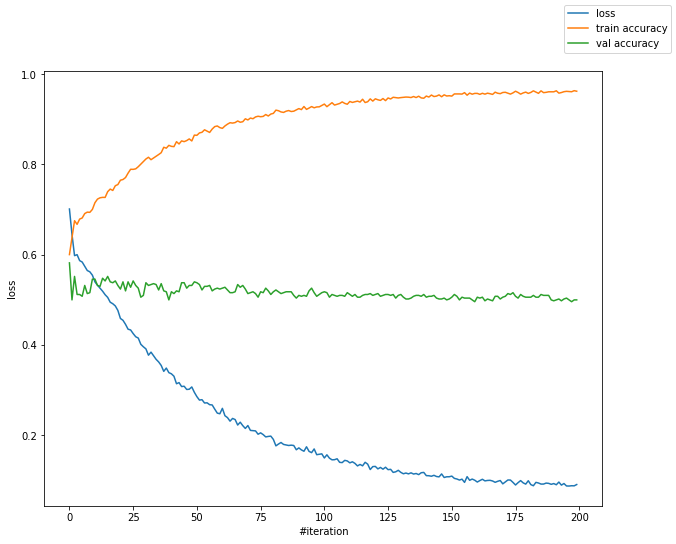

In [25]:
fig = plt.figure(figsize=(10, 8))    
plt.xlabel("#iteration")
plt.ylabel("loss")
plt.plot(loss_history, label='loss')
plt.plot(train_history, label='train accuracy')
plt.plot(val_history, label='val accuracy')
fig.legend()
plt.show()

In [26]:
print("best model:", best_model_name)

best_model = torch.load(open(best_model_name, 'rb'))
print(best_model)

best model: classifier_0_0.582.ckpt
Sequential(
  (0): Linear(in_features=768, out_features=256, bias=True)
  (1): Dropout(p=0.66, inplace=False)
  (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): ReLU(inplace=True)
  (4): Linear(in_features=256, out_features=256, bias=True)
  (5): Dropout(p=0.66, inplace=False)
  (6): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): ReLU(inplace=True)
  (8): Linear(in_features=256, out_features=2, bias=True)
)


Accuracy: 0.582
ROC AUC: 0.618944


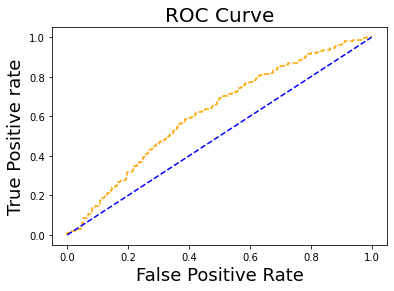

In [27]:
best_model.eval()
for i_step, (x, y) in enumerate(DataLoader(features_val_dataset, batch_size=5000)):
    prediction = best_model(x)

acc_score = accuracy_score(np.array([x.item() for x in labels_val]), torch.max(prediction, 1)[1])
auc_score = roc_auc_score(np.array([x.item() for x in labels_val]), prediction[:,1].detach().numpy())
prettyTable.add_row(['Neural Network', acc_score, auc_score])

fpr, tpr, thresh = roc_curve(labels_val, prediction[:,1].detach().numpy(), pos_label=1)

random_probs = [0 for i in range(len(labels_val))]
p_fpr, p_tpr, _ = roc_curve(labels_val, random_probs, pos_label=1)
auc_score = roc_auc_score(labels_val, prediction[:,1].detach().numpy())

print('Accuracy: ', acc_score, '\n', 'ROC AUC: ', auc_score, sep='')

plt.plot(fpr, tpr, linestyle='--',color='orange')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.title('ROC Curve', fontsize=20)
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive rate',fontsize=18)

plt.show();

In [28]:
print(prettyTable)

+----------------+----------+----------+
|   Model name   | Accuracy | ROC AUC  |
+----------------+----------+----------+
| Neural Network |  0.582   | 0.618944 |
+----------------+----------+----------+
